# Coffee Leaf Diseases Prediction

## Overview
This notebook is a reproduction of the coffee leaf disease classification method described in the research paper below, using machine learning techniques with RGB and CMY color features.

## References

### Research Paper
- **Title**: Comparative Analysis of the Performance of the Decision Tree and K-Nearest Neighbors Methods in Classifying Coffee Leaf Diseases
- **Authors**: Adie Suryadi, Murhaban Murhaban, Rivansyah Suhendra
- **Published in**: Department of Information Technology, Teuku Umar University, Indonesia
- **URL**: [https://aptikom-journal.id/conferenceseries/article/view/649/272](https://aptikom-journal.id/conferenceseries/article/view/649/272)

### Dataset
- **Dataset**: Coffee Leaf Diseases
- **Source**: Kaggle
- **URL**: [https://www.kaggle.com/datasets/badasstechie/coffee-leaf-diseases/code](https://www.kaggle.com/datasets/badasstechie/coffee-leaf-diseases/code)

## Methodology
This implementation extracts color-based features from coffee leaf images:
- **RGB features**: Mean and standard deviation for each R, G, B channel (6 features)
- **CMY features**: Mean and standard deviation for each C, M, Y channel (6 features)
- **Total**: 12 color-based features per image

The features are then used to classify coffee leaves into four categories:
- Miner
- Phoma
- Rust
- No disease

## Preprocessing Data

In [ ]:
import numpy as np
from PIL import Image
import os

def load_and_extract_features(image_dir, labels_df):
    features_list = []
    valid_indices = []
    
    for idx, row in labels_df.iterrows():
        img_path = os.path.join(image_dir, f"{row['id']}.jpg")
        
        if os.path.exists(img_path):
            img = Image.open(img_path)
            img_resized = img.resize((100, 50), Image.Resampling.BILINEAR) # resize to 100x50
            img_array = np.array(img_resized).astype('float32') / 255.0 # normalize 
            
            features_list.append(img_array)
            valid_indices.append(idx)
        else:
            print(f"Warning: {img_path} not found")
    
    features_array = np.array(features_list)
    labels = labels_df.loc[valid_indices].reset_index(drop=True)
    labels = labels.drop(columns=['id'], axis=1)
    
    return features_array, labels

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

train_label_df = pd.read_csv('dataset/train_classes.csv')
test_label_df = pd.read_csv('dataset/test_classes.csv')

train_features, train_labels = load_and_extract_features('dataset/coffee-leaf-diseases/train/images', train_label_df)
test_features, test_labels = load_and_extract_features('dataset/coffee-leaf-diseases/test/images', test_label_df)

train_features_flat = train_features.reshape(train_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

X_train, X_valid, y_train, y_valid = train_test_split(
    train_features_flat, 
    train_labels,
    test_size=0.2,
    stratify=train_labels,
    random_state=123
)
print(f"\nShape of X_train: {X_train.shape}")


Shape of X_train: (1011, 15000)


In [4]:
label_counts = np.sum(train_labels.values, axis=0)
print("Label distribution in training set:")
for label, count in zip(train_labels.columns, label_counts):
    print(f"{label}: {count} samples")

Label distribution in training set:
miner: 332 samples
rust: 308 samples
phoma: 388 samples


In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline as SKPipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV

def build_model(model_type, model, param_grid):
    pipeline = SKPipeline([
        ('pca', PCA(random_state=123)),
        ('scaler', StandardScaler()),
        ('multi_output', MultiOutputClassifier(model, n_jobs=-1))
    ])
    
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='f1_macro',
        cv=10,
        n_jobs=-1
    )
    
    grid.fit(X_train, y_train)
    print(f"Best parameters for {model_type}: {grid.best_params_}")
    print(f"Best F1 Micro Score for {model_type}: {grid.best_score_}")
    
    return grid.best_estimator_

best_multilable_dt = build_model(
    'Decision Tree',
    DecisionTreeClassifier(),
    {
        'pca__n_components': [10, 20, 50],
        'multi_output__estimator__criterion': ['gini', 'entropy'],
        'multi_output__estimator__max_depth': [5, 8, 13, 18, None],
        'multi_output__estimator__min_samples_split': [2, 5],
        'multi_output__estimator__min_samples_leaf': [1, 3],
        'multi_output__estimator__class_weight': ['balanced', None],
        'multi_output__estimator__min_impurity_decrease': [0.0, 0.001, 0.01]
    }
)

best_multilable_knn = build_model(
    'KNN',
    KNeighborsClassifier(),
    {
        'pca__n_components': [10, 20, 50],
        'multi_output__estimator__n_neighbors': [1, 3, 5, 7, 9],
        'multi_output__estimator__metric': ['euclidean', 'manhattan', 'cosine'],
        'multi_output__estimator__weights': ['uniform', 'distance']
    }
)

Best parameters for Decision Tree: {'multi_output__estimator__class_weight': None, 'multi_output__estimator__criterion': 'entropy', 'multi_output__estimator__max_depth': None, 'multi_output__estimator__min_impurity_decrease': 0.001, 'multi_output__estimator__min_samples_leaf': 1, 'multi_output__estimator__min_samples_split': 2, 'pca__n_components': 20}
Best F1 Micro Score for Decision Tree: 0.7214366150201946
Best parameters for KNN: {'multi_output__estimator__metric': 'manhattan', 'multi_output__estimator__n_neighbors': 1, 'multi_output__estimator__weights': 'uniform', 'pca__n_components': 20}
Best F1 Micro Score for KNN: 0.7338600957069737


In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ---------- Evaluation on Validation Set ----------
# ---------- Decision Tree ----------
y_pred_valid_multilabel_dt = best_multilable_dt.predict(X_valid)

print("\n=== Decision Tree Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_valid, y_pred_valid_multilabel_dt))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_multilabel_dt, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_multilabel_dt, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_multilabel_dt, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_multilabel_dt, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_multilabel_dt, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_multilabel_dt, average='macro', zero_division=0))

# ---------- KNN ----------
y_pred_valid_multilabel_knn = best_multilable_knn.predict(X_valid)

print("\n=== KNN Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_valid, y_pred_valid_multilabel_knn))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_multilabel_knn, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_multilabel_knn, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_multilabel_knn, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_multilabel_knn, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_multilabel_knn, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_multilabel_knn, average='macro', zero_division=0))


=== Decision Tree Overall Metrics ===
Accuracy (subset accuracy): 0.6600790513833992
Precision (micro): 0.7956989247311828
Recall (micro): 0.7219512195121951
F1-score (micro): 0.7570332480818415
Precision (macro): 0.7946127946127947
Recall (macro): 0.7182416854548003
F1-score (macro): 0.7535792709705754

=== KNN Overall Metrics ===
Accuracy (subset accuracy): 0.6798418972332015
Precision (micro): 0.75
Recall (micro): 0.7024390243902439
F1-score (micro): 0.72544080604534
Precision (macro): 0.7449994902913923
Recall (macro): 0.6937406855439643
F1-score (macro): 0.7170912599024136


In [7]:
# ---------- Evaluation on Test Set ----------
# ---------- Decision Tree ----------
y_pred_test_multilabel_dt = best_multilable_dt.predict(test_features_flat)

print("\n=== Decision Tree Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(test_labels, y_pred_test_multilabel_dt))
print("Precision (micro):", precision_score(test_labels, y_pred_test_multilabel_dt, average='micro', zero_division=0))
print("Recall (micro):", recall_score(test_labels, y_pred_test_multilabel_dt, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(test_labels, y_pred_test_multilabel_dt, average='micro', zero_division=0))
print("Precision (macro):", precision_score(test_labels, y_pred_test_multilabel_dt, average='macro', zero_division=0))
print("Recall (macro):", recall_score(test_labels, y_pred_test_multilabel_dt, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(test_labels, y_pred_test_multilabel_dt, average='macro', zero_division=0))

# ---------- KNN ----------
y_pred_test_multilabel_knn = best_multilable_knn.predict(test_features_flat)

print("\n=== KNN Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(test_labels, y_pred_test_multilabel_knn))
print("Precision (micro):", precision_score(test_labels, y_pred_test_multilabel_knn, average='micro', zero_division=0))
print("Recall (micro):", recall_score(test_labels, y_pred_test_multilabel_knn, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(test_labels, y_pred_test_multilabel_knn, average='micro', zero_division=0))
print("Precision (macro):", precision_score(test_labels, y_pred_test_multilabel_knn, average='macro', zero_division=0))
print("Recall (macro):", recall_score(test_labels, y_pred_test_multilabel_knn, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(test_labels, y_pred_test_multilabel_knn, average='macro', zero_division=0))


=== Decision Tree Overall Metrics ===
Accuracy (subset accuracy): 0.4725
Precision (micro): 0.5477031802120141
Recall (micro): 0.5236486486486487
F1-score (micro): 0.5354058721934369
Precision (macro): 0.530231859067741
Recall (macro): 0.5228587962962963
F1-score (macro): 0.5209563630616262

=== KNN Overall Metrics ===
Accuracy (subset accuracy): 0.51
Precision (micro): 0.5709876543209876
Recall (micro): 0.625
F1-score (micro): 0.5967741935483871
Precision (macro): 0.5786753705970352
Recall (macro): 0.6403356481481483
F1-score (macro): 0.6059936032009673


In [14]:
# try SMOTE
from sklearn.base import clone
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold # CV with SMOTE

def build_model_smote(model_type, model, param_grid):
    
    # A list to store best estimators from each fold
    best_estimators_list = []
    
    # A list to store best macro scores from each fold
    best_macro_scores = []
    
    y_train_np = np.array(y_train)
    X_train_np = np.array(X_train)
    
    # Loop through each label for multi-label classification
    for i in range(y_train.shape[1]):
        print(f"Processing label {i+1}/{y_train.shape[1]}")
        
        y_label = y_train_np[:, i]
        
        if len(np.unique(y_label)) < 2:
            print(f"Skipping label {i+1} since it has only one class.")
            continue
        
        # Define pipeline for single label
        single_label_pipeline = ImbPipeline([
            ('pca', PCA(random_state=123)),
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=123)),
            ('model', clone(model))
        ])
        
        # Use StratifiedKFold for better representation of classes in each fold
        cv_splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
        
        grid = RandomizedSearchCV(
            estimator=single_label_pipeline,
            param_distributions=param_grid,
            n_iter=200,
            scoring='f1',
            cv=cv_splitter,
            n_jobs=-1,
            random_state=123
        )
        
        grid.fit(X_train_np, y_label)
        
        print(f"Best parameters for {model_type} label {i+1}: {grid.best_params_}")
        print(f"Best F1 score for label {i+1}: {grid.best_score_}")
        best_estimators_list.append(grid.best_estimator_)
        best_macro_scores.append(grid.best_score_)
        
    # Combine best estimators (custom multi-output)
    class CustomMultiOutputEstimator:
        def __init__(self, estimators):
            self.estimators = estimators
            
        def predict(self, X):
            # Generate predictions for each estimator and stack them
            predictions = [est.predict(X).reshape(-1, 1) for est in self.estimators]
            return np.hstack(predictions)
        
        def predict_proba(self, X):
            # Generate probability predictions for each estimator
            proba_list = []
            for est in self.estimators:
                proba = est.predict_proba(X)[:, 1].reshape(-1, 1)
                proba_list.append(proba)
                
            return np.hstack(proba_list)
    
    return CustomMultiOutputEstimator(best_estimators_list)

best_multilable_dt_smote = build_model_smote(
    'Decision Tree',
    DecisionTreeClassifier(),
    {
        'pca__n_components': [10, 20, 50],
        'smote__k_neighbors': [3, 5, 7, 11],
        'model__criterion': ['gini', 'entropy'],
        'model__max_depth': [5, 8, 13, 18, None],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 3],
        'model__class_weight': ['balanced', None],
        'model__min_impurity_decrease': [0.0, 0.001, 0.01]
    }
)

best_multilable_knn_smote = build_model_smote(
    'KNN',
    KNeighborsClassifier(),
    {
        'pca__n_components': [10, 20, 50],
        'smote__k_neighbors': [3, 5, 7, 11],
        'model__n_neighbors': [1, 3, 5, 7, 9],
        'model__metric': ['euclidean', 'manhattan', 'cosine'],
        'model__weights': ['uniform', 'distance']
    }
)

Processing label 1/3
Best parameters for Decision Tree label 1: {'smote__k_neighbors': 7, 'pca__n_components': 10, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__min_impurity_decrease': 0.0, 'model__max_depth': 18, 'model__criterion': 'entropy', 'model__class_weight': 'balanced'}
Best F1 score for label 1: 0.6264684739347228
Processing label 2/3
Best parameters for Decision Tree label 2: {'smote__k_neighbors': 11, 'pca__n_components': 10, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__min_impurity_decrease': 0.001, 'model__max_depth': None, 'model__criterion': 'entropy', 'model__class_weight': None}
Best F1 score for label 2: 0.7181857568692696
Processing label 3/3
Best parameters for Decision Tree label 3: {'smote__k_neighbors': 7, 'pca__n_components': 20, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__min_impurity_decrease': 0.001, 'model__max_depth': None, 'model__criterion': 'entropy', 'model__class_weight': None}
Be

In [15]:
# ---------- Evaluation on Validation Set ----------
# ---------- Decision Tree ----------
y_pred_valid_multilabel_dt_smote = best_multilable_dt_smote.predict(X_valid)

print("\n=== Decision Tree Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_valid, y_pred_valid_multilabel_dt_smote))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_multilabel_dt_smote, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_multilabel_dt_smote, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_multilabel_dt_smote, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_multilabel_dt_smote, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_multilabel_dt_smote, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_multilabel_dt_smote, average='macro', zero_division=0))

# ---------- KNN ----------
y_pred_valid_multilabel_knn_smote = best_multilable_knn_smote.predict(X_valid)

print("\n=== KNN Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_valid, y_pred_valid_multilabel_knn_smote))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_multilabel_knn_smote, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_multilabel_knn_smote, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_multilabel_knn_smote, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_multilabel_knn_smote, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_multilabel_knn_smote, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_multilabel_knn_smote, average='macro', zero_division=0))


=== Decision Tree Overall Metrics ===
Accuracy (subset accuracy): 0.6837944664031621
Precision (micro): 0.7456140350877193
Recall (micro): 0.8292682926829268
F1-score (micro): 0.7852193995381063
Precision (macro): 0.7458131670389675
Recall (macro): 0.8255696944221534
F1-score (macro): 0.7814900240435314

=== KNN Overall Metrics ===
Accuracy (subset accuracy): 0.6403162055335968
Precision (micro): 0.6723404255319149
Recall (micro): 0.7707317073170732
F1-score (micro): 0.7181818181818181
Precision (macro): 0.6806487986815855
Recall (macro): 0.7633586813914683
F1-score (macro): 0.716853745997644


In [16]:
# ---------- Evaluation on Test Set ----------
# ---------- Decision Tree ----------
y_pred_test_multilabel_dt_smote = best_multilable_dt_smote.predict(test_features_flat)

print("\n=== Decision Tree Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(test_labels, y_pred_test_multilabel_dt_smote))
print("Precision (micro):", precision_score(test_labels, y_pred_test_multilabel_dt_smote, average='micro', zero_division=0))
print("Recall (micro):", recall_score(test_labels, y_pred_test_multilabel_dt_smote, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(test_labels, y_pred_test_multilabel_dt_smote, average='micro', zero_division=0))
print("Precision (macro):", precision_score(test_labels, y_pred_test_multilabel_dt_smote, average='macro', zero_division=0))
print("Recall (macro):", recall_score(test_labels, y_pred_test_multilabel_dt_smote, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(test_labels, y_pred_test_multilabel_dt_smote, average='macro', zero_division=0))

# ---------- KNN ----------
y_pred_test_multilabel_knn_smote = best_multilable_knn_smote.predict(test_features_flat)

print("\n=== KNN Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(test_labels, y_pred_test_multilabel_knn_smote))
print("Precision (micro):", precision_score(test_labels, y_pred_test_multilabel_knn_smote, average='micro', zero_division=0))
print("Recall (micro):", recall_score(test_labels, y_pred_test_multilabel_knn_smote, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(test_labels, y_pred_test_multilabel_knn_smote, average='micro', zero_division=0))
print("Precision (macro):", precision_score(test_labels, y_pred_test_multilabel_knn_smote, average='macro', zero_division=0))
print("Recall (macro):", recall_score(test_labels, y_pred_test_multilabel_knn_smote, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(test_labels, y_pred_test_multilabel_knn_smote, average='macro', zero_division=0))


=== Decision Tree Overall Metrics ===
Accuracy (subset accuracy): 0.3875
Precision (micro): 0.4595300261096606
Recall (micro): 0.5945945945945946
F1-score (micro): 0.5184094256259205
Precision (macro): 0.46299887782982047
Recall (macro): 0.6067708333333334
F1-score (macro): 0.5202421877746143

=== KNN Overall Metrics ===
Accuracy (subset accuracy): 0.4525
Precision (micro): 0.5129411764705882
Recall (micro): 0.7364864864864865
F1-score (micro): 0.6047156726768377
Precision (macro): 0.5239588820368651
Recall (macro): 0.7549189814814814
F1-score (macro): 0.6149579950086119


#### Confusion Matrix Heatmap

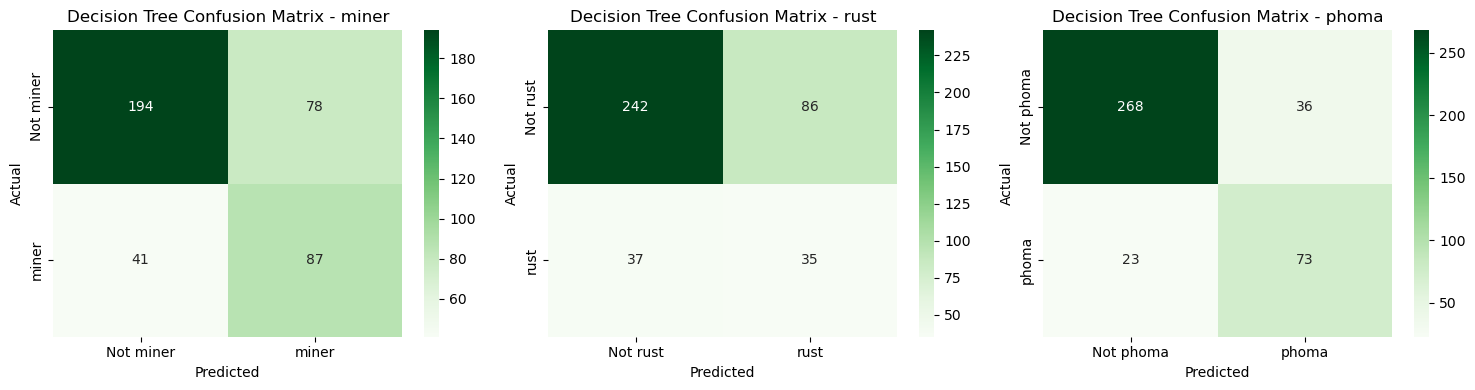

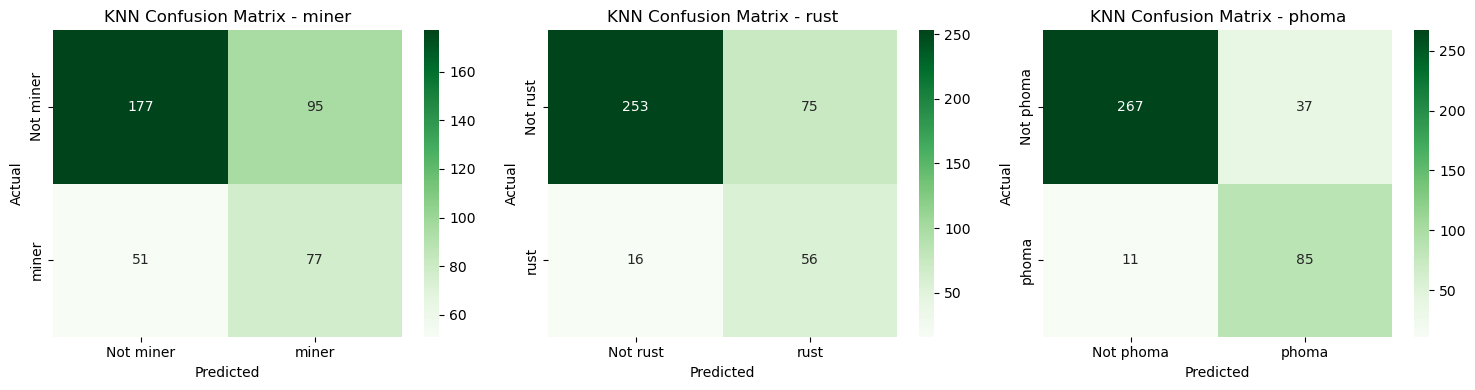

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

test_labels_array = np.array(test_labels)
labels = test_labels.columns

def plot_confusion_matrix(model_type, pred):
    
    pred_array = np.array(pred)
    
    plt.figure(figsize=(15, 4))
    
    for i, label_name in enumerate(labels):
        y_true_label = test_labels_array[:, i]
        y_pred_label = pred_array[:, i]
        
        cm = confusion_matrix(y_true_label, y_pred_label)
        
        plt.subplot(1, len(labels), i + 1)
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Greens',
            xticklabels=['Not ' + label_name, label_name],
            yticklabels=['Not ' + label_name, label_name]
        )
        plt.title(f'{model_type} Confusion Matrix - {label_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
    
    plt.tight_layout()
    plt.show()

# Decision Tree
plot_confusion_matrix(
    'Decision Tree',
    y_pred_test_multilabel_dt_smote
)

# KNN
plot_confusion_matrix(
    'KNN',
    y_pred_test_multilabel_knn_smote
)

#### ROC-AUC Curves

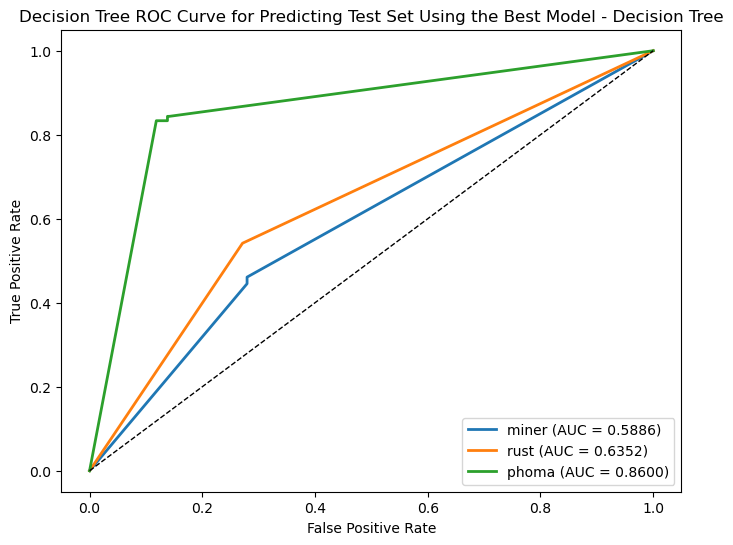

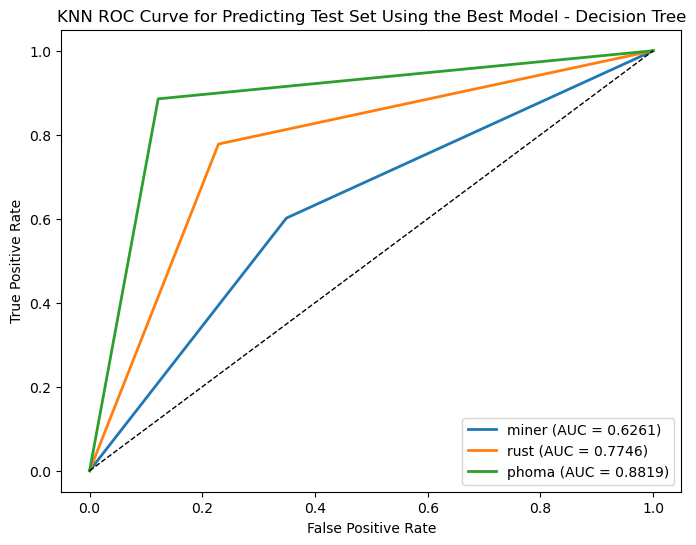

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model_type, model):
    y_score = model.predict_proba(test_features_flat)
    
    plt.figure(figsize=(8, 6))
    for i, class_name in enumerate(labels):
        fpr_dt, tpr_dt, _ = roc_curve(test_labels_array[:, i], y_score[:, i])
        roc_auc_dt_best = auc(fpr_dt, tpr_dt)
        plt.plot(
            fpr_dt,
            tpr_dt,
            lw=2,
            label=f'{class_name} (AUC = {roc_auc_dt_best:.4f})'
        )
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_type} ROC Curve for Predicting Test Set Using the Best Model - Decision Tree')
    plt.legend()
    plt.show()

# Decision Tree
plot_roc_curve('Decision Tree', best_multilable_dt_smote)

# KNN
plot_roc_curve('KNN', best_multilable_knn_smote)

## Save models

To save scikit-learn models, we use `joblib` which is more efficient for large numpy arrays:

In [ ]:
import joblib

joblib.dump(best_multilable_knn_smote, 'best_multilabel_knn_smote.pkl')
joblib.dump(best_multilable_dt_smote, 'best_multilabel_dt_smote.pkl')

['knn_model.pkl']